# Les systèmes de recommandation


Les systèmes de recommandation visent à maximiser la consommation en proposant à l'utilisateur ou consommateur les éléments le plus susceptibles de l'intéresser.
Ces systèmes se basent sur caractéristiques des utilisateurs qui se ressemblent pour sa "prédiction", on distingue trois méthodes de comparaison pour ce type d'algorithmes :

    => Basé sur l'objet lui même, ou "content-based approach"
    => Basé sur la personne
    => Basé sur la société qui l'entoure et ses influences, ou "Collaborative filtering, context aware"
    => Ou bien basé sur un melange de ces trois donnée, appellé recommandation hybride
    
Aujourd'hui, les content based approch et les collaborative filtering !
Nous allons étudier des données de films, et leur évaluation par des utilisateurs.

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Analyse des datas
Chargeons les données depuis le fichier 'ml-100k/u.data' et on le croise avec les titres des films

In [ ]:

names = ['user_id', 'item_id', 'rating', 'timestamp']
data = pd.read_csv('ml-100k/u.data', sep='\t', names=names)
films = pd.DataFrame(data.groupby(1)['rating'].mean())

Comme nous voyons, nous avons une colonne pour les users, une pour les films (item_id), une pour levaluation, et la dernière dont nous ne nous occuperons pas, désigme le moment auquel le film a été visionné en temps universel.<br>
Funfact : les gagnant du netflix_prize ont pimpés leur algorithme notamment avec un parametre deduisant le biais temporel.
<br>

Jetons un coup d'oeil au nombre d'items et d'users :

In [ ]:
n_users = data.user_id.unique().shape[0]
n_items = data.item_id.unique().shape[0]
print (str(n_users) + ' users')
print (str(n_items) + ' items')
data.head()

Etudions les ratings a l'aide de describe()

In [ ]:
print(films.describe())

Regardons le nombre de ratings par film

In [ ]:
films['number_of_ratings'] = data.groupby(1)['rating'].count()
films.head()

Visualisons maintenant la distribution des avis.

In [ ]:
films['rating'].hist(bins=50)

Puis la ponderation qui lui est associée...

In [ ]:
films['number_of_ratings'].hist(bins=60)

Et fusionnons les deux !

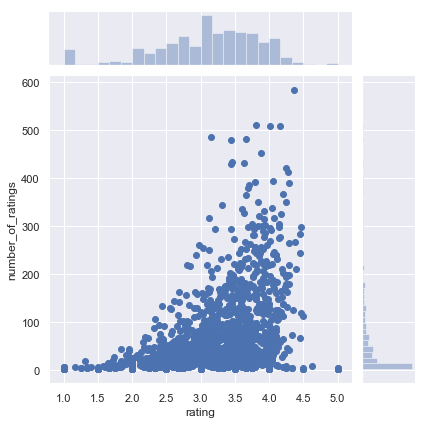

In [70]:
sns.jointplot(x='rating', y='number_of_ratings', data=films)

Comme nous pouvons le voir la majorité des films n'ont que peu de rating.<br>
Notre dataset peut etre biaisé par ce defaut. Nous allons tout de meme continuer, et voir si les resultats sont coherents.

##  Mise en place du collaborative filtering

Decalons notre liste pour l'aligner sur l'index 0

In [71]:
ratings = np.zeros((n_users, n_items))
for row in data.itertuples():
    ratings[row[1]-1, row[2]-1] = row[3]
ratings

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

Calculons maintenant l'indice de parcimonie (indiquant quel pourcentage des films chaque utilisateur a evalué en moyenne)

In [72]:
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print ('Sparsity: {:4.2f}%'.format(sparsity))

Sparsity: 6.31%


Divisons notre dataset en deux :

In [73]:
def train_test_split(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], size=10, replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
    return train, test

In [74]:
train, test = train_test_split(ratings)

Définissons une fonction calculant la similarité cosinus, <br>
elle est tres lente si faite en boucle for, utilisez les fonctions numpy dot et diagonal.<br>
Elle devra pouvoir s'appliquer soit aux users soit aux items ! (utilisez la methode translate)

In [75]:
#epsilon est la pour eviter les divisions par 0
def cosine_similarity(ratings, kind='user', epsilon=1e-9):
    if kind == 'user':
        sim = ratings.dot(ratings.T) + epsilon
    elif kind == 'item':
        sim = ratings.T.dot(ratings) + epsilon
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return (sim / norms / norms.T)

In [76]:
user_similarity = cosine_similarity(train, kind='user')
item_similarity = cosine_similarity(train, kind='item')

Definissons une fonction de prediction basique, qui prendra parti des map de similarité

In [77]:
def predict(ratings, similarity, kind='user'):
    if kind == 'user':
        return similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif kind == 'item':
        return ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])

Et une dernière pour calculer la fonction de cout "mean squared error"

In [78]:
from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

Et on lance le tout !

In [79]:
item_prediction = predict(train, item_similarity, kind='item')
user_prediction = predict(train, user_similarity, kind='user')

In [80]:
print ('User-based CF MSE: ' + str(get_mse(user_prediction, test)))
print ('Item-based CF MSE: ' + str(get_mse(item_prediction, test)))
print(user_prediction, test)

User-based CF MSE: 8.398979809276382
Item-based CF MSE: 11.52804436160989
[[2.27662341e+00 7.64112817e-01 4.44548374e-01 ... 8.87788576e-04
  5.91859051e-04 7.03898515e-03]
 [1.79766917e+00 3.37993436e-01 3.03308365e-01 ... 5.48803193e-03
  3.65868795e-03 2.79551971e-03]
 [1.20547167e+00 2.96484581e-01 2.35141317e-01 ... 1.38367686e-02
  9.22451239e-03 3.35773320e-03]
 ...
 [2.59556269e+00 4.72191511e-01 4.08084903e-01 ... 1.40539843e-03
  9.36932288e-04 3.85096012e-03]
 [1.93099619e+00 6.04011253e-01 2.98243609e-01 ... 3.42887015e-03
  2.28591343e-03 5.36038862e-03]
 [2.33676250e+00 8.84281584e-01 4.75975993e-01 ... 1.10857106e-14
  7.39047371e-15 7.78909086e-03]] [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Vos valeurs doivent s'approcher de 8.3 pour le user-based et de 11.5 pour le item-based.

### Optimisation :

Comme nous l'avons vus sur le graph, les datas souffent de beaucoup de biais qu'il faut prendre en compte avant leur traitement<br>
Utilisons la methode top-k, qui consiste betement a ne prendre en compte que les k utilisateur les plus proches du notre.

In [81]:
def predict_topk(ratings, similarity, kind='user', k=40):
    pred = np.zeros(ratings.shape)
    if kind == 'user':
        for i in range(ratings.shape[0]):
            top_k_users = [np.argsort(similarity[:,i])[:-k-1:-1]]
            for j in range(ratings.shape[1]):
                pred[i, j] = similarity[i, :][top_k_users].dot(ratings[:, j][top_k_users]) 
                pred[i, j] /= np.sum(np.abs(similarity[i, :][top_k_users]))
    if kind == 'item':
        for j in range(ratings.shape[1]):
            top_k_items = [np.argsort(similarity[:,j])[:-k-1:-1]]
            for i in range(ratings.shape[0]):
                pred[i, j] = similarity[j, :][top_k_items].dot(ratings[i, :][top_k_items].T) 
                pred[i, j] /= np.sum(np.abs(similarity[j, :][top_k_items]))        
    return pred

Comme vous allez le voir, le cout est maintenant divisé par deux !<br>
Ce genre d'optimisation est rapide a mettre en place, et tres efficace.<br>
Vous devriez obtenir autour de 6.5 pour les user-based et 7.8 pour les item-based.

In [82]:
pred = predict_topk(train, user_similarity, kind='user', k=30)
print ('Top-k User-based CF MSE: ' + str(get_mse(pred, test)))

pred = predict_topk(train, item_similarity, kind='item', k=15)
print ('Top-k Item-based CF MSE: ' + str(get_mse(pred, test)))


Top-k User-based CF MSE: 6.567620259029522
Top-k Item-based CF MSE: 7.50109706758453


## Hyperparameters customisation :
Nous allons maintenant tracer un graphique du cout en fonction des k-premiers utilisateurs, et voir comment potentiellement ameliorer les performances de l'algorithme :

In [83]:
k_array = [5, 15, 30, 50, 100]
user_train_mse = []
user_test_mse = []
item_test_mse = []
item_train_mse = []


def get_mse(pred, actual):
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

for k in k_array:
    print(k)
    user_pred = predict_topk(train, user_similarity, kind='user', k=k)
    item_pred = predict_topk(train, item_similarity, kind='item', k=k)
    
    user_train_mse += [get_mse(user_pred, train)]
    user_test_mse += [get_mse(user_pred, test)]
    
    item_train_mse += [get_mse(item_pred, train)]
    item_test_mse += [get_mse(item_pred, test)]  

5
15
30
50
100


KeyboardInterrupt: 

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

pal = sns.color_palette("Set2", 2)

plt.figure(figsize=(8, 8))
plt.plot(k_array, user_train_mse, c=pal[0], label='User-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, user_test_mse, c=pal[0], label='User-based test', linewidth=5)
plt.plot(k_array, item_train_mse, c=pal[1], label='Item-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, item_test_mse, c=pal[1], label='Item-based test', linewidth=5)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('k', fontsize=30);
plt.ylabel('MSE', fontsize=30);

Ce graph represente le cout des differents set de data en fonction du nombre d'users pris en compte.<br>
Il va nous permettre de determiner quels sont les k ideaux !<br>
Nous pouvons voir ici que les valeurs les plus optimales sont autour de 40 pour le user-based test, et de 20 pour l'item-based test.

## Visualisation
Maintenant ajoutons les noms de film pour voir le resultat de notre travail !
Vous allez devoir ouvrir le fichier u.item, y lire les index de chaque film pour les rentrer manuellement.

In [98]:
movies_index = {}
with open('ml-100k/u.item', 'r', encoding = 'ISO-8859-1') as f:
    for line in f.readlines():
        info = line.split('|')
        movies_index[int(info[0])-1] = info[1]
        
def top_movies(similarity, mapper, movie_idx, k=6):
    return [mapper[x] for x in np.argsort(similarity[movie_idx,:])[:-k-1:-1]]
top_k_movies(item_similarity, movies_index, 500)

['Dumbo (1941)',
 'Cinderella (1950)',
 'Pinocchio (1940)',
 'Snow White and the Seven Dwarfs (1937)',
 'Beauty and the Beast (1991)',
 'Alice in Wonderland (1951)']

## Bonus
Essayez de mettre en place une fonction predict qui normalise les données des users, <br>
en prenant en compte leur note max et leur note min pour les ramener a une echelle commune.

In [ ]:
def predict_nobias(ratings, similarity, kind='user'):
    if kind == 'user':
        user_bias = ratings.mean(axis=1)
        ratings = (ratings - user_bias[:, np.newaxis]).copy()
        pred = similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
        pred += user_bias[:, np.newaxis]
    elif kind == 'item':
        item_bias = ratings.mean(axis=0)
        ratings = (ratings - item_bias[np.newaxis, :]).copy()
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
        pred += item_bias[np.newaxis, :]
        
    return pred

In [ ]:
user_pred = predict_nobias(train, user_similarity, kind='user')
print ('Bias-subtracted User-based : ' + str(get_mse(user_pred, test)))

item_pred = predict_nobias(train, item_similarity, kind='item')
print ('Bias-subtracted Item-based : ' + str(get_mse(item_pred, test)))
